<a href="https://colab.research.google.com/github/csargin/Dog_breed_identification/blob/main/Global_ai_Dog_breed_identification_ipynb_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro





## https://www.kaggle.com/competitions/dog-breed-identification
You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal is to create a classifier capable of determining a dog's breed from a photo.

# Import Libraries

In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import cv2 as cv

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.transform import resize
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import image

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
from tqdm import tqdm

import gc

from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

import tensorflow as tf
from keras import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

# Load dataset from kaggle

In [2]:
#https://www.kaggle.com/discussions/general/74235

! pip install -q kaggle

! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json

from google.colab import userdata

# make new JSON file
with open('/content/kaggle.json', 'w') as f:
  text = '{"username":"' + userdata.get("kaggle_username") + '","key":"' + userdata.get('kaggle_psw') + '"}'
  f.write(text)

! chmod 600 ~/.kaggle/kaggle.json
! cp kaggle.json ~/.kaggle/
! kaggle datasets list

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                  LLM: 7 prompt training dataset                     41MB  2023-11-15 07:32:56            857         77  1.0              
thedrcat/daigt-proper-train-dataset                             DAIGT Proper Train Dataset                        119MB  2023-11-05 14:03:25            936        108  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset              Customer Shopping Trends Dataset                  146KB  2023-10-05 06:45:37          30666        573  1.0              
joebeachcapital/30000-spotify-songs                             30000 

In [3]:
! kaggle competitions download -c 'dog-breed-identification'

 99% 683M/691M [00:05<00:00, 132MB/s]
100% 691M/691M [00:05<00:00, 133MB/s]


In [4]:
! unzip -o dog-breed-identification.zip -d dog-breed-identification # unzip in order to overwrite files

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: dog-breed-identification/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog-breed-identification/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog-breed-identification/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog-breed-identification/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog-breed-identification/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog-breed-identification/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog-breed-identification/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog-breed-identification/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog-breed-identification/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog-breed-identification/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog-breed-identification/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog-breed-identification/tr

In [5]:
train_dir = '/content/dog-breed-identification/train'
test_dir = '/content/dog-breed-identification/test'
df = pd.read_csv('/content/dog-breed-identification/labels.csv') # Load the labels

# Preprocessing

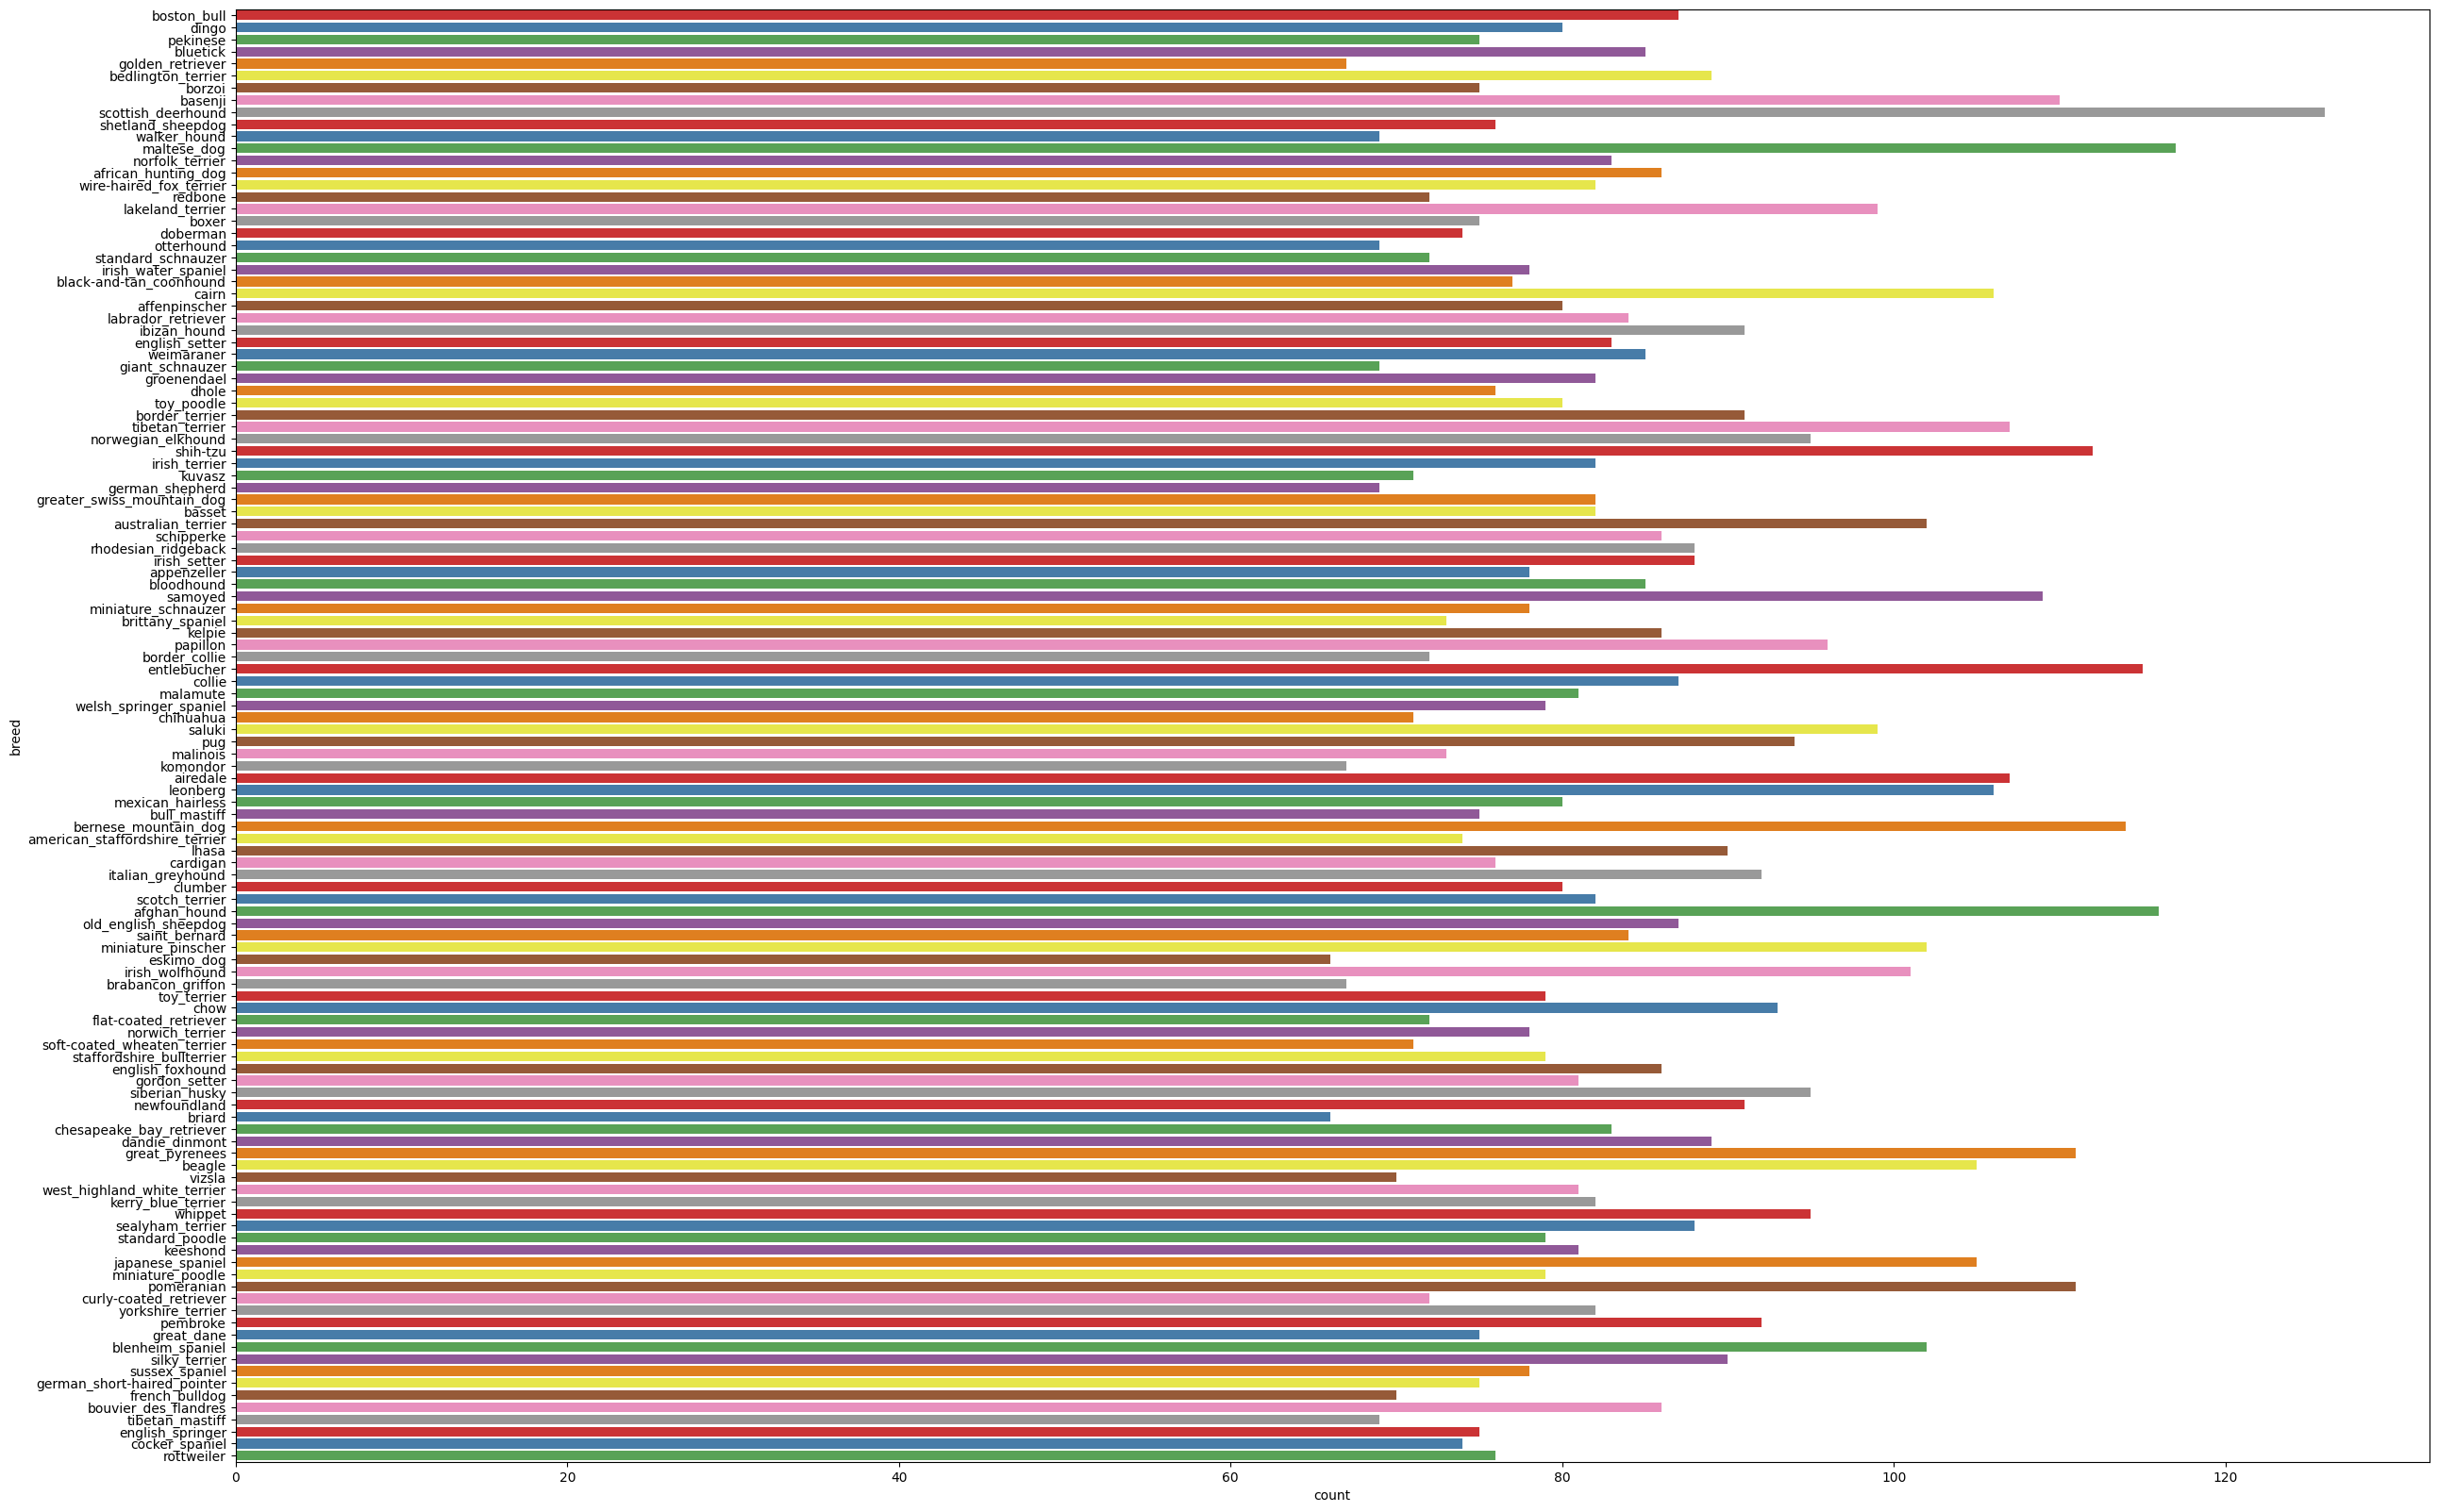

In [6]:
plt.figure(figsize=(30,20))
sns.countplot(y="breed",data=df,palette="Set1")
plt.show()

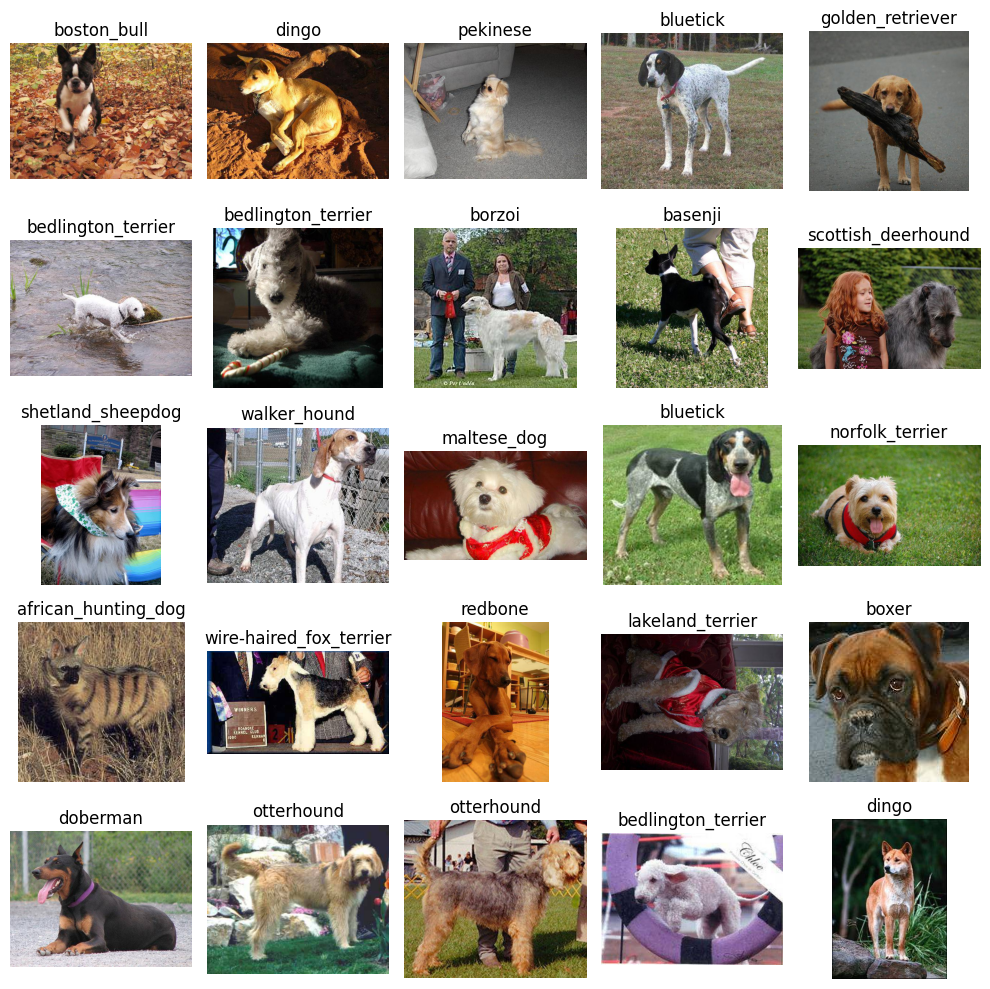

In [7]:
nrow=5
ncol=5
fig,ax=plt.subplots(nrow,ncol,figsize=(10,10))
for i,(img_id,breed) in enumerate(df[["id","breed"]].values[: nrow*ncol]):
    image_path=os.path.join(train_dir,img_id+".jpg")
    image=cv.imread(image_path)
    image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
    row=i//ncol
    col=i%ncol
    ax[row,col].imshow(image)
    ax[row,col].set_title(breed)
    ax[row,col].axis("off")

plt.tight_layout()
plt.show()

In [8]:
print("Total number of unique Dog Breeds :",len(df.breed.unique()))

Total number of unique Dog Breeds : 120


In [9]:
from sklearn.preprocessing import LabelEncoder
num_breed = 120
image_size = 200
batch_size = 32
encoder = LabelEncoder()

In [10]:
breed=list(df["breed"].value_counts().keys())
new=sorted(breed,reverse=True)[: num_breed]
df=df.query("breed in @new")
df

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [11]:
df['image_file'] = df['id'].apply(lambda x: x + ".jpg")
df.head()

id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                             image_file  
0  000bec180eb18c7604dcecc8fe0dba07.jpg  
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  001cdf01b096e06d78e9e5112d419397.jpg  
3  00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  0021f9ceb3235effd7fcde7f7538ed62.jpg

In [12]:
import numpy as np
from tensorflow.keras.applications.mobilenet import preprocess_input

In [13]:
train_data=np.zeros((len(df),image_size,image_size,3),dtype="float32")
for i,img_id in enumerate(df["image_file"]):
    img=cv.resize(cv.imread(train_dir + "/" + img_id,cv.IMREAD_COLOR),((image_size,image_size)))
    img_array=preprocess_input(np.expand_dims(np.array(img[...,: : -1].astype(np.float32)).copy(),axis=0))
    train_data[i]=img_array

In [14]:
train_data[i]

array([[[ 0.45098042,  0.45098042,  0.4666667 ],
        [ 0.4666667 ,  0.4666667 ,  0.48235297],
        [ 0.5137255 ,  0.5137255 ,  0.52156866],
        ...,
        [-0.42745095, -0.44313723, -0.4352941 ],
        [-0.32549018, -0.32549018, -0.34117645],
        [-0.42745095, -0.42745095, -0.44313723]],

       [[ 0.41960788,  0.41960788,  0.43529415],
        [ 0.48235297,  0.48235297,  0.49803925],
        [ 0.45098042,  0.45098042,  0.4666667 ],
        ...,
        [-0.4823529 , -0.4980392 , -0.49019605],
        [-0.4980392 , -0.5058824 , -0.5058824 ],
        [-0.27843136, -0.27843136, -0.27843136]],

       [[ 0.5137255 ,  0.5137255 ,  0.5294118 ],
        [ 0.43529415,  0.43529415,  0.45882356],
        [ 0.3803922 ,  0.3803922 ,  0.39607847],
        ...,
        [-0.45098037, -0.4588235 , -0.4588235 ],
        [-0.08235294, -0.08235294, -0.08235294],
        [-0.5764706 , -0.5764706 , -0.5764706 ]],

       ...,

       [[ 0.5764706 ,  0.5764706 ,  0.5764706 ],
        [ 0

In [15]:
lab = df["breed"].unique().tolist()
print(lab)

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malino

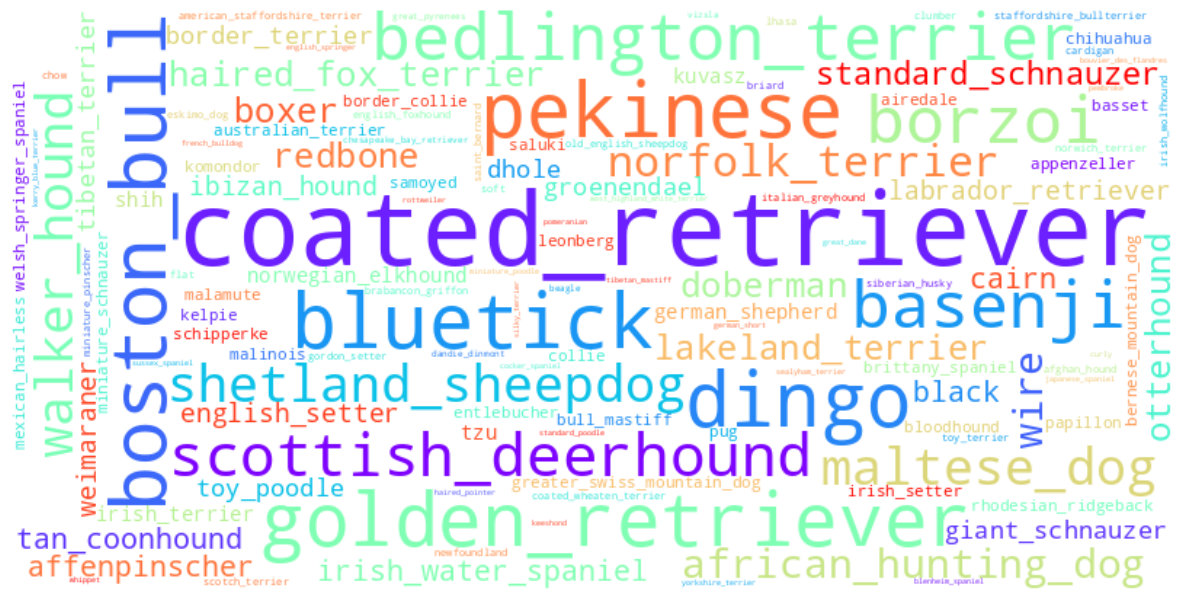

In [16]:
from wordcloud import WordCloud
text = ' '.join(lab)
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap="rainbow").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
label_data = encoder.fit_transform(df["breed"].values)
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train_data,label_data,test_size=0.2,random_state=42)

In [19]:
print("************************************************************")
print("Train Data Shape :",x_train.shape)
print("************************************************************")
print("Test Data Shape :",x_test.shape)
print("************************************************************")
print("Train Label Data Shape :",y_train.shape)
print("************************************************************")
print("Test Label Data Shape :",y_test.shape)
print("************************************************************")

************************************************************
Train Data Shape : (8177, 200, 200, 3)
************************************************************
Test Data Shape : (2045, 200, 200, 3)
************************************************************
Train Label Data Shape : (8177,)
************************************************************
Test Label Data Shape : (2045,)
************************************************************


#Model

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=batch_size)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(x_test,
                                   y_test,
                                   batch_size=batch_size)

In [21]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

resnet = ResNet50V2(input_shape = [image_size,image_size,3], weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(num_breed, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=["accuracy"])
model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [22]:
history = model.fit(train_generator,steps_per_epoch= x_train.shape[0] // batch_size,epochs=1,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)

255/255 [==============================] - 1716s 7s/step - loss: 2.7971 - accuracy: 0.3128 - val_loss: 1.4544 - val_accuracy: 0.5818


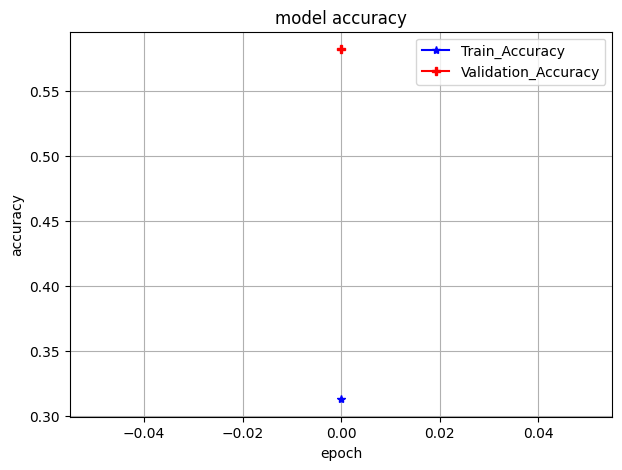

In [23]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'],label="Train_Accuracy",color="blue",marker="*")
plt.plot(history.history['val_accuracy'],label="Validation_Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

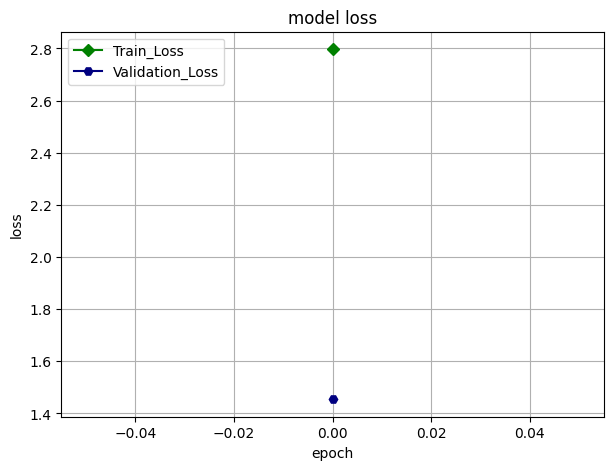

In [24]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],color="green",marker="D")
plt.plot(history.history['val_loss'],color="navy",marker="H")
plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train_Loss', 'Validation_Loss'], loc='upper left')
plt.show()

64/64 [==============================] - 308s 5s/step


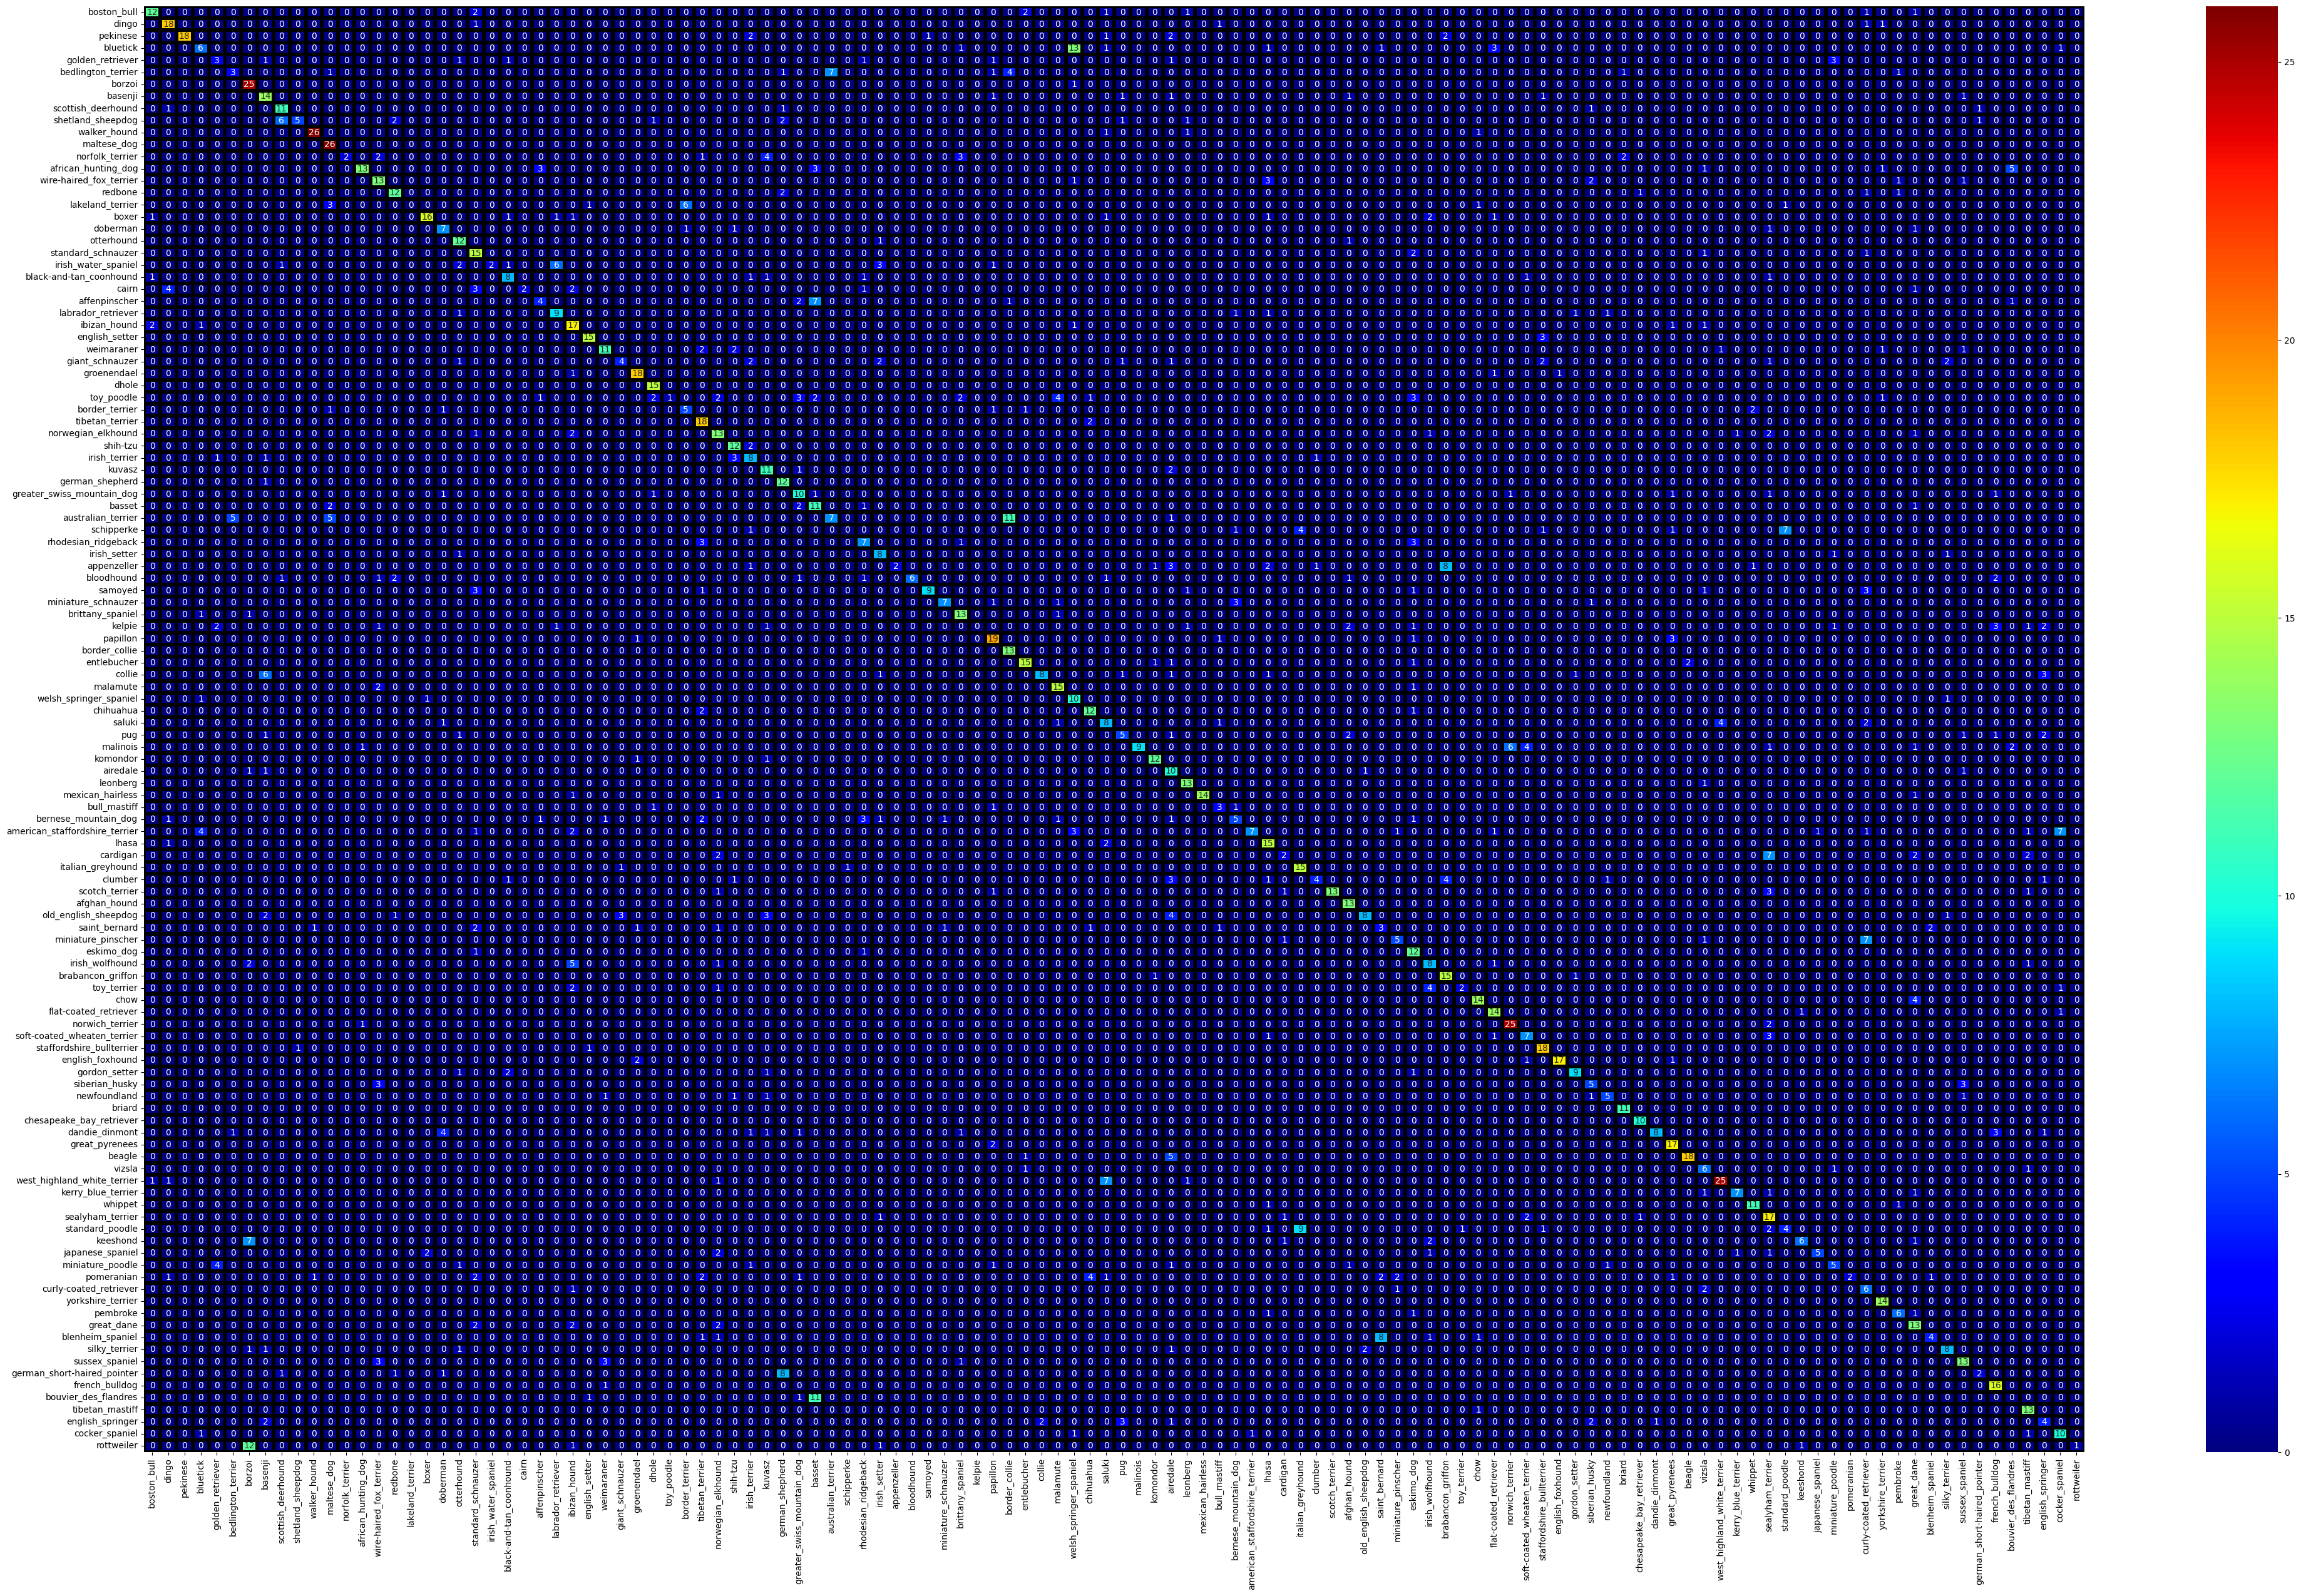

In [25]:
pre=model.predict(x_test)
predict=np.argmax(pre,axis=1)

from sklearn.metrics import confusion_matrix, classification_report
plt.figure(figsize=(50,30))
cf=confusion_matrix(y_test,predict)
sns.heatmap(cf,annot=True,fmt="d",cmap="jet",lw=4,linecolor="black",xticklabels=lab,yticklabels=lab)
plt.show()

In [26]:
print(classification_report(y_test,predict,target_names=lab))

                                precision    recall  f1-score   support

                   boston_bull       0.71      0.60      0.65        20
                         dingo       0.67      0.82      0.73        22
                      pekinese       1.00      0.69      0.82        26
                      bluetick       0.43      0.22      0.29        27
              golden_retriever       0.30      0.25      0.27        12
            bedlington_terrier       0.33      0.16      0.21        19
                        borzoi       0.51      0.96      0.67        26
                       basenji       0.47      0.70      0.56        20
            scottish_deerhound       0.55      0.73      0.63        15
             shetland_sheepdog       0.83      0.26      0.40        19
                  walker_hound       0.93      0.90      0.91        29
                   maltese_dog       0.68      1.00      0.81        26
               norfolk_terrier       1.00      0.14      0.25  

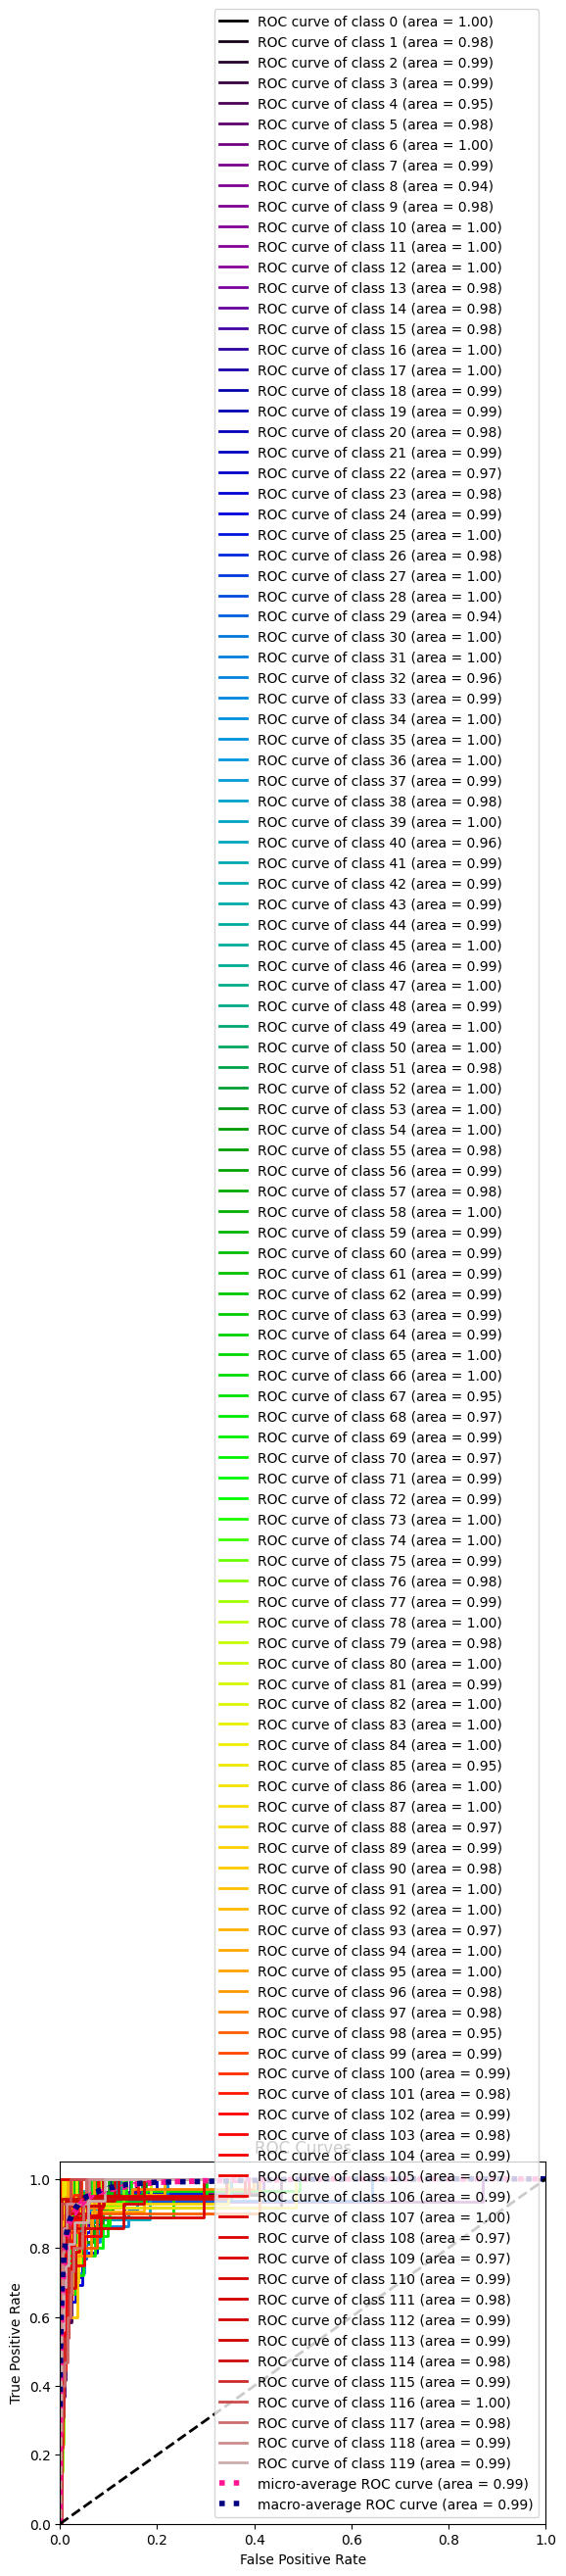

In [29]:
!pip install scikit-plot
import scikitplot as skplt

skplt.metrics.plot_roc(y_test, pre)
plt.show()

<Figure size 2000x1500 with 0 Axes>

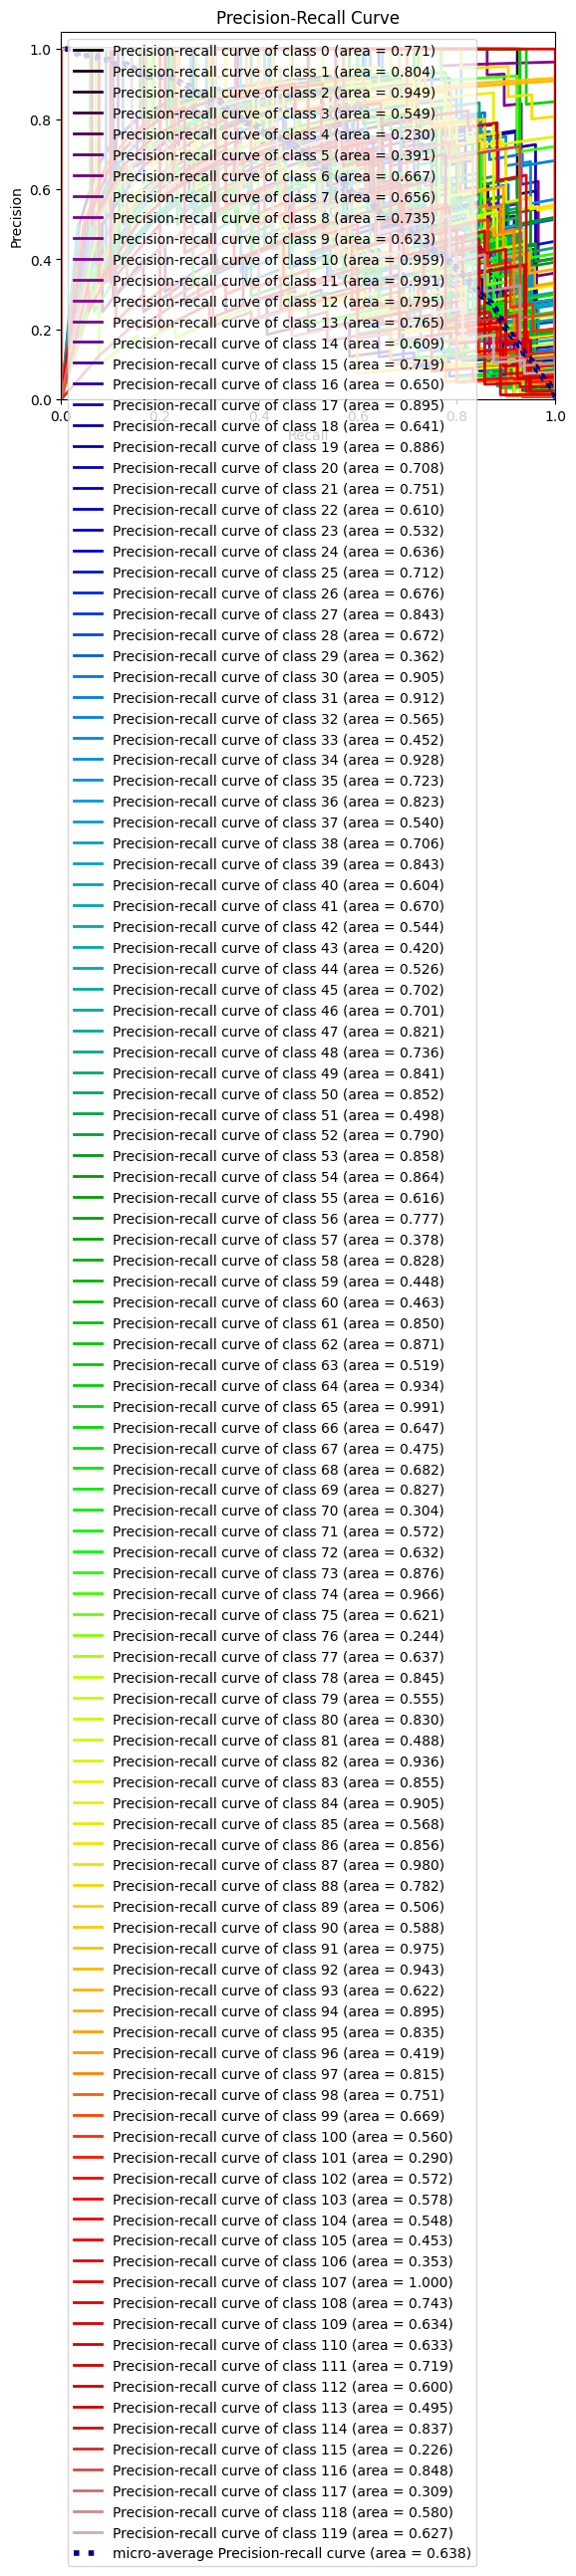

In [30]:
plt.figure(figsize=(20,15))
skplt.metrics.plot_precision_recall(y_test, pre)
plt.show()

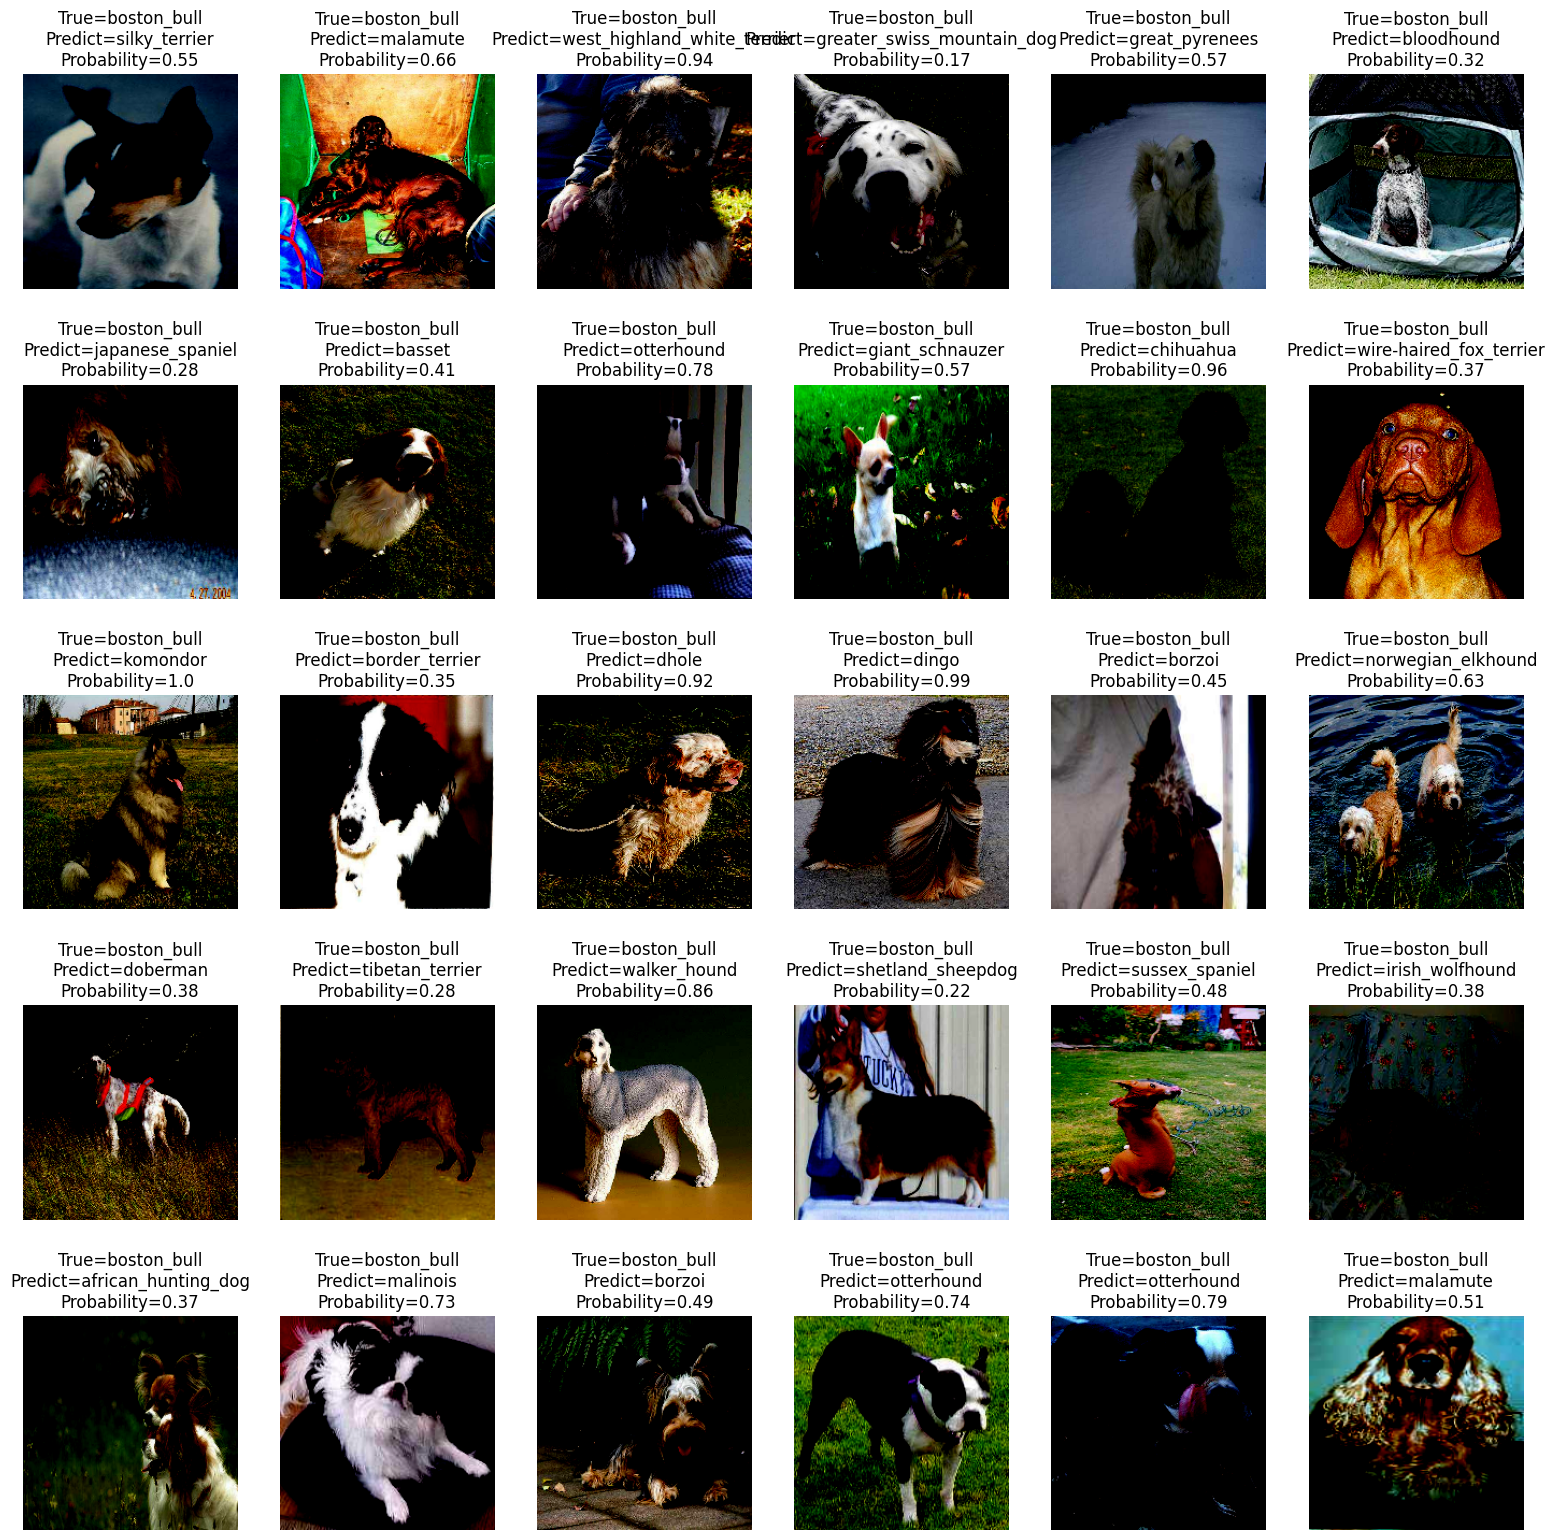

In [31]:
row = 5
column = 6

fig, ax = plt.subplots(row, column)
fig.set_size_inches(15, 15)

index = 0
for m in range(0, row):
    for n in range(0, column):
        true_data = np.argmax(y_test[index])  # Get the true class label
        pred_data = predict[index]  # Get the predicted class label
        probability = round(pre[index][pred_data], 2)
        ax[m][n].axis("off")
        ax[m][n].set_title("True=" + str(lab[true_data]) + "\nPredict=" + str(lab[pred_data]) + "\nProbability=" + str(probability))
        ax[m][n].imshow(x_test[index])
        index += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.20)
plt.show()

# Test with real image

1/1 [==============================] - 0s 340ms/step


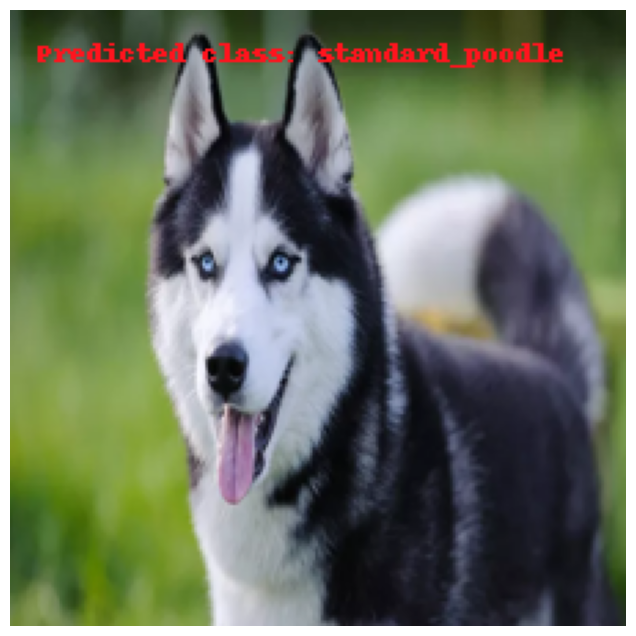

In [35]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import tensorflow as tf

# Define the URL of the image
image_url = "https://www.dailypaws.com/thmb/KMJM_zupItmjx1g-tAAZ-7L-hbE=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/siberian-husky-100800827-2000-9449ca147e0e4b819bce5189c2411188.jpg"
# Load the image from the URL
response = requests.get(image_url)
image_path = Image.open(BytesIO(response.content))
image_resized_rgb = image_path.resize((224, 224)).convert('RGB')
image_array_rgb = np.array(image_resized_rgb)
image_scale_rgb = image_array_rgb.astype("float32") / 255.0
image_reshape_rgb = image_scale_rgb.reshape(1, 224, 224, 3)
final_pred = model.predict(image_reshape_rgb)[0]
max_prob = np.argmax(final_pred)
results = lab
my_predict = results[max_prob]
image_draw = ImageDraw.Draw(image_resized_rgb)
image_draw.text((10, 10), f"Predicted class: {my_predict}", fill=(255, 20, 30))
image_resized_rgb.save("my_image.png")
plt.figure(figsize=(8, 8))
plt.imshow(image_resized_rgb)
plt.axis("off")
plt.show()